In [26]:
import numpy as np
from scipy import linalg
import scipy.sparse.linalg as spla
from scipy.sparse import csc_matrix, diags, eye, kron

# plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D 

In [53]:
a = diags(np.ones(2), 0)
b = diags([10, 12], 0)
(a - b).toarray()

array([[ -9.,   0.],
       [  0., -11.]])

## helper functions

In [2]:
def printmatrix(mat, **kwargs):
    fp = kwargs.get("fp", 3)    # number of floating points
    bs = kwargs.get("bs", 8)   # number of blank-spaces
    format_dict = {
        'float_kind': lambda x: f"{x:>{bs}.{fp}f}",
        'bool': lambda x: False if x == 0 else True,
        }
    formatter = kwargs.get("formatter", format_dict)
    linewidth = kwargs.get("linewidth", None)
    if linewidth is None:
        linewidth = kwargs.get("lw", 100)
    with np.printoptions(formatter=formatter, linewidth=linewidth):
        print(mat)

# Exercise 2b) 5- and 9-point Laplacian

## c) Implement 5-point Laplacian scheme. Check expected convergence
Use the exact solution:
$$\begin{align*}
    u_\mathrm{exact}(x,y) &= \sin{\left(4\pi(x + y)\right)} + \cos{\left(4\pi xy\right)}
\end{align*}$$

## The 5-point Laplacian

Let $u_{ij} = u(x_i, y_j)$, for a step-size equal in $x$ and $y$
$$\begin{align*}
    \nabla^2 u &= \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
    \\
    \frac{\partial^2 u}{\partial x^2} &\approx \frac{u_{i-1,j} - 2u_{ij} + u_{i+1,j}}{h^2}
    \\
    \frac{\partial^2 u}{\partial y^2} &\approx \frac{u_{i,j-1} - 2u_{ij} + u_{i, j+1}}{h^2}
    \\
    \nabla^2u &\approx \frac{u_{i-1,j} - 2u_{ij} + u_{i+1,j}}{h^2} + \frac{u_{i,j-1} - 2u_{ij} + u_{i, j+1}}{h^2} 
    \\ &= \frac{u_{i-1,j} + u_{i,j-1} - 4u_{ij} + u_{i+1,j} + u_{i,j+1}}{h^2}

\end{align*}$$

## Creating grid

For computational relevancy we want to make the solution array $u_{ij}$ 2D $\to$ 1D; if doing this row-wise we get

$$\begin{align*}
    U = \begin{bmatrix}
        u_{00} & u_{10} & u_{20} \\
        u_{01} & u_{11} & u_{21} \\
        u_{02} & u_{12} & u_{22} \\
    \end{bmatrix}
    \to 
    \begin{bmatrix}
        u_{00} \\ u_{10} \\ u_{20} \\
        u_{01} \\ u_{11} \\ u_{21} \\
        u_{02} \\ u_{12} \\ u_{22} \\
    \end{bmatrix}
\end{align*}$$

This gives us $N\times N$ uknowns, and so the solution matrix, $A$, is $A\in \mathbb{R}^{N^2\times N^2}$

Remember, that for a 5-point Laplacian, we should have $u_{00} = u_{20} = {u_02} = u_{22} = 0$ and the left, right, top, and bottom neighbours, $u_{10} = u_{01} = u_{21} = u_{12} = 1$, and the center point should be $u_{11} = - 4$

$$\begin{align*}
    A_{11} = \begin{bmatrix}
        0 & 1 & 0 \\
        1 & -4 & 1 \\
        0 & 1 & 0 \\
    \end{bmatrix}
    \to 
    \begin{bmatrix}
        0 & 1 & 0 &
        1 & -4 & 1 &
        0 & 1 & 0 \\
    \end{bmatrix}
\end{align*}$$

for the $k$'th index $k:=k_{ij} = i + jN$.

So, for the 5-point Laplacian, the system matrix, $A$, should have
* A diagonal of $k_{ii} = -4$
* NN poitns of element $k_{i\pm 1, j}, k_{i,k\pm1} = 1$:
    * $k_{i\pm 1, j} = k_{ij} \pm 1$
    * $k_{i, j\pm 1} = k_{ij} \pm N$

In [3]:
from sympy import symbols, diff, sin, cos, pi, latex
from IPython.display import Math
x, y = symbols("x y")
u = sin(4*pi*(x + y)) + cos(4*pi*x*y)
upp = u.diff(x,2) + u.diff(y,2)
upp = upp.simplify()

display(Math(rf"$\nabla^2 = {latex(upp)}$"))

<IPython.core.display.Math object>

We want to create a 5-point Laplacian, and we will compare it to a given function:
$$\begin{align*}
    u_\mathrm{exact}(x,y) &= \sin{\left(4\pi(x + y)\right)} + \cos{\left(4\pi xy\right)}
    \\
    \nabla^2 u_\mathrm{exact}(x,y) &= -(4\pi)^2\bigg( \Big(x^2 + y^2\Big) \cos(4\pi x y) + 2 \sin(4\pi(x+y))\bigg)
\end{align*}$$

When evaluating the expression on $x_i,y_j$ we have $U_{ij} = u(x_i,y_j)$
Applying the double centeret stencil, $D_i^2U_{ij}$ gives us
$$\begin{align*}
    \dfrac{\partial^2 U_{ij}}{\partial x_i^2} &\approx \dfrac{U_{i+1,j} -2U_{i,j} + U_{i-1,j}}{h^2}
    \\
    \dfrac{\partial^2 U_ij}{\partial y_j^2} &\approx \dfrac{U_{i,j+1} -2U_{i,j} + U_{i,j-1}}{h^2}
    \\
    \nabla^2U_{ij} &\approx \dfrac{U_{i+1,j} + U_{i,j+1} + U_{i-1,j} + U_{i,j-1} -4U_{i,j}}{h^2}
\end{align*}$$

This yields the Laplacian matrix
$$\begin{align*}
    A &= \dfrac{1}{h^2}
    \begin{pmatrix}
        -4 & 1 & 0 & 0 & 0 & 0 \\
        1  &-4 & 1 & 0 & 0 & 0\\
        0  & 1 &-4 & 1 & 0 & 0\\
        0  & 0 & 1 &-4 & 1 & 0\\
        0  & 0 & 0 & 1 & -4& 1\\
        0  & 0 & 0 & 0 & 1 &-4
    \end{pmatrix}
\end{align*}$$

Now if we want to solve the grid, it is convenient to use 1D representation of the grid, and therefore we construct a matrix being $A\in \mathbb{R}^{N^2\times N^2}$ to our 1D representation of the stencil-approximation $U\in\mathbb{R}^{N^2}$

$$\begin{align*}
    A &= \frac{1}{h^2}\left(T_2\otimes I + I \otimes T_2\right), \quad T_\gamma = \begin{pmatrix}
    -\gamma & 1 & 0 \\ 
     1 & -\gamma & 1 \\ 
     0 & 1 & -\gamma \end{pmatrix}
     \\
     &= \frac{1}{h^2} 
     \left(\begin{array}{c|c|c}
        T_4 & I & 0 \\\hline 
        I & T_4 & I \\\hline
        0 & I & T_4
     \end{array}\right)
\end{align*}$$

In [ ]:
def laplace_5_point(N):
    # T2  = np.diag(-2*np.ones(N), 0) #  main-diagonal
    # T2 += np.diag(np.ones(N-1), -1) # lower-diagonal
    # T2 += np.diag(np.ones(N-1), 1)  # upper-diagonal
    main     = -2*np.ones(N)
    off_diag = np.ones(N-1)
    T2 = diags([off_diag, main, off_diag], offsets=[1, 0, -1], shape=(N,N), format="csc")
    I = eye(N) # Identity matrix of size N x N
    A = kron(T2, I) + kron(I, T2)
    return (N+1)**2 * A # A / h**2  = A * (N+1)**2

def u_exact(x, y):
    C = 4* np.pi
    return np.sin(C*(x+y)) + np.cos(C*x*y)

def upp(x,y):
    C = 4 * np.pi
    return -C**2 * ( 2*np.sin(C*(x + y)) + (x**2 + y**2) * np.cos(C*x*y))


def solve_poisson(N, f_func, g_func):
    h = 1/(N+1)
    xy = np.linspace(0,1, num=N+2, endpoint=True)
    X, Y = np.meshgrid(xy, xy, indexing="xy")
    X_interior = X[1:-1, 1:-1]
    Y_interior = Y[1:-1, 1:-1]
    
    F = f_func(X_interior, Y_interior).flatten()
    
    bound_values = np.zeros((N,N))
    bound_values[0, :]  = g_func(X, 0)[1:-1, 1:-1]
    bound_values[-1, :] = g_func(X, 1)[1:-1, 1:-1]
    bound_values[:, 0]  = g_func(0, Y)[1:-1, 1:-1]
    bound_values[:, -1] = g_func(1, Y)[1:-1, 1:-1]
    
    
    bound_mask = np.zeros((N,N))
    
    

In [25]:
Ns = [2**i*10 for i in range(5)]
errors = []

for N in Ns:
    print(f"{N = }")
    h = 1/(N+1)
    xy = np.linspace(0, 1, num=N+2, endpoint=True) # Full grid (including boudnary)
    X, Y = np.meshgrid(xy, xy, indexing="xy")
    EXACT_FULL = u_exact(X, Y)
    EXACT = EXACT_FULL[1:-1, 1:-1].flatten()
    
        
    X_interior = X[1:-1, 1:-1]
    Y_interior = Y[1:-1, 1:-1]
    f = upp(X_interior, Y_interior).flatten()
    
    BC_MASK = np.ones((N,N), dtype=bool)
    BC_MASK[1:-1, 1:-1] = False
    
    
    BC = np.zeros((N,N))
    for i in [0, -1]:
        for j in [0, -1]:
            BC[i, :] = EXACT_FULL[i, 1:-1] # top and bottom
            BC[:, j] = EXACT_FULL[1:-1, j] # right and left
    # BC[ 0, :] = EXACT_FULL[   0, 1:-1] # top boundary
    # BC[-1, :] = EXACT_FULL[  -1, 1:-1] # bottom boundary
    # BC[ :, 0] = EXACT_FULL[1:-1, 0   ] # left boundary
    # BC[ :,-1] = EXACT_FULL[1:-1, -1  ] # rigth boundary
    # for i in range(N):
    #     for j in range(N):
    #         index = i*N + j
    #         if i == 0: # top boundary
    #             f[index] -= BC[0, j+1] * (N+1)**2
    #         if i == N-1: # bottom boundary
    #             f[index] -= BC[-1, j+1] * (N+1)**2
    #         if j == 0: # left boundary
    #             f[index] -= BC[i+1, 0] * (N+1)**2
    #         if j == N-1: # right boundary
    #             f[index] -= BC[i+1, -1] * (N+1)**2 
    
    print("applying mask")
    f[BC_MASK.flatten()]  -= BC.flatten()[BC_MASK.flatten()]
    
    # print(f"{BC_MASK.shape = }")
    # print(f"{BC.shape = }")
    # print(f"{f.shape = }")
    
    f = csc_matrix(f).T
    print("making laplacian")
    A = laplace_5_point(N)
    print(f"solving system\t {A.shape = }")
    U_numeric = spla.spsolve(A, f)
    
    print("computing error")
    print("\n")
    err = linalg.norm(U_numeric - EXACT, np.inf)
    errors.append(err)

errors = np.array(errors)
orders = np.log2(errors[:-1] / errors[1:])

N = 10
applying mask
making laplacian
solving system	 A.shape = (100, 100)
computing error


N = 20
applying mask
making laplacian
solving system	 A.shape = (400, 400)
computing error


N = 40
applying mask
making laplacian
solving system	 A.shape = (1600, 1600)
computing error


N = 80
applying mask
making laplacian
solving system	 A.shape = (6400, 6400)
computing error


N = 160
applying mask
making laplacian
solving system	 A.shape = (25600, 25600)
computing error




In [23]:
for N, err, order in zip(Ns, errors, orders):
    print(f"{N:<12} | {err:.6e} | {order:.2f}")

10           | 3.590834e+04 | -3.68
20           | 4.587200e+05 | -3.85
40           | 6.607199e+06 | -3.93
80           | 1.007962e+08 | -3.96


In [ ]:
N = 4
xy = np.linspace(0, 1, num=N, endpoint=True) # uniform grid
X, Y = np.meshgrid(xy, xy, indexing="xy")
# printmatrix(Y)
U_full = u_exact(X, Y)
# top     = u_exact(0, xy)
# bottom  = u_exact(1, xy)
# left    = u_exact(xy, 0)
# right   = u_exact(xy, 1)
# np.all(bottom == right), np.all(left == top)
U_full[1:-1, 1:-1] = 0
printmatrix(U_full)


    


U0 = np.zeros((N**2,))
L = laplace_5_point(N)

[[   1.000    0.134    1.866    1.000]
 [   0.134    0.000    0.000   -1.366]
 [   1.866    0.000    0.000    0.366]
 [   1.000   -1.366    0.366    1.000]]


In [ ]:

m= 50
x = np.linspace(0, 1, m+2)
y = np.linspace(0, 1, m+2)
X, Y = np.meshgrid(x, y, indexing="xy")

U = np.zeros((m+2, m+2))
upp = np.zeros((m, m))
U[0, :] = u_exact(0, y)
U[-1, :] = u_exact(1, y)


C:\Users\basti\AppData\Local\Temp\ipykernel_33400\2680777888.py:102: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


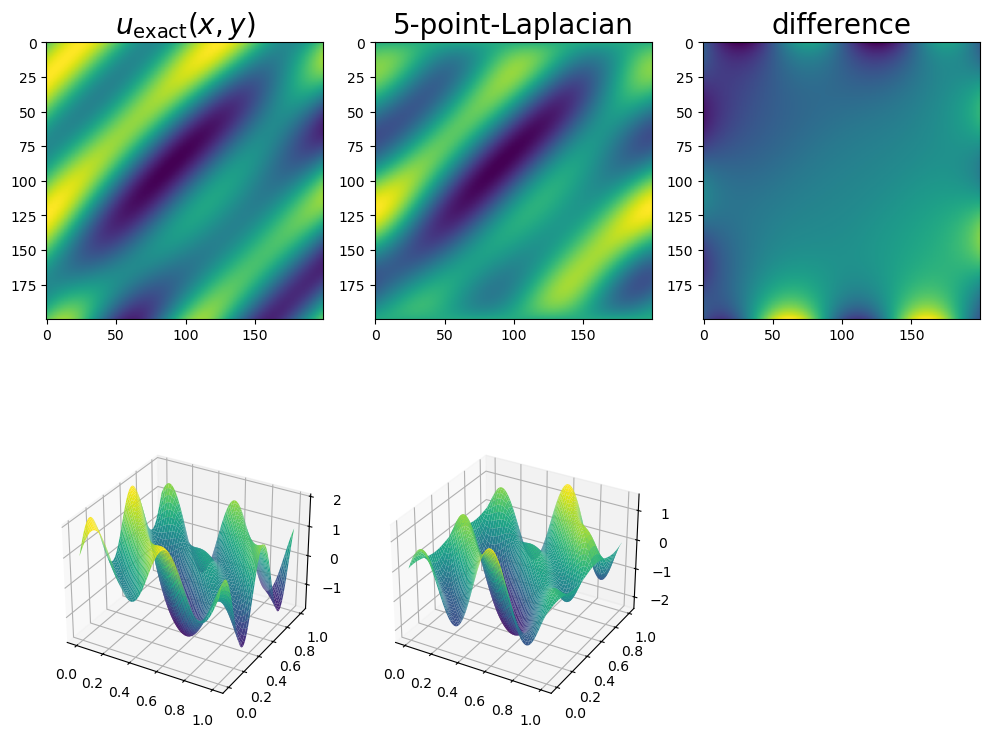

In [ ]:
def u_exact(x, y):  
    C = 4*np.pi
    return np.sin(C*(x + y)) + np.cos(C*x*y)

def RHS(x, y):
    C = 4 * np.pi
    return -C**2 * ( 2*np.sin(C*(x + y)) + (x**2 + y**2) * np.cos(C*x*y))

def laplace_5_point(N, h):
    # M = len(u) # number of interior points
    size = N * N
    
    diag = -4*np.ones(size) /h**2
    
    off_diag = np.ones(size-1) /h**2
    # off_diag[np.arange(1, size) % N == 0] = 0 # On boundary the value should be 0
    
    up_down_diag = np.ones(size - N) /h**2
    
    A = diags(diagonals=[up_down_diag, off_diag, diag, off_diag, up_down_diag], 
              offsets=[N, 1, 0, -1, -N], 
              shape=(size, size), format="csc")
    return A


def solve_poisson(N):
    h = 1/(N+1)
    # xy = np.arange(0, 1, step=h)
    xy = np.linspace(0, 1, num=N)
    
    X, Y = np.meshgrid(xy, xy, indexing="xy")
    
    # f = RHS(X_interior, Y_interior).flatten()
    f = RHS(X, Y).flatten()
    # print(f"{f.shape = }")
    A = laplace_5_point(N, h)
    # u_boundary = u_exact(X, Y)
    # print(f"{u_boundary[1:-1, 0].shape = }")
    # f = f - (u_boundary[1:-1, 0] + u_boundary[1:-1, -1] + u_boundary[0, 1:-1] + u_boundary[-1, 1:-1]).flatten() / h**2
    u_h = splinalg.spsolve(A, f)
    return X, Y, u_h, h, A

def convergence(grid_sizes):
    errors = []
    h_values = []
    A_norm_values = []
    
    
    for N in grid_sizes:
        X, Y, u_h, h, A_h = solve_poisson(N)
        u_exact_vals = u_exact(X, Y).flatten()
        # print(u_exact_vals.shape)
        err = linalg.norm(u_h - u_exact_vals, np.inf)
        errors.append(err)
        h_values.append(h)
        A_norm_values.append(splinalg.norm(A_h, np.inf))
        
    return h_values, errors, A_norm_values



## For plotting imshow() and 3D
M = 200
xs = np.linspace(0, 1, num=M)[:, None]
ys = np.linspace(0, 1, num=M)[None, :]
X, Y = np.meshgrid(xs, ys, indexing="ij")

f = RHS(xs, ys)
A = laplace_5_point(M, 1/(M+1))
U = splinalg.spsolve(A, csc_matrix(f.flatten()).T).reshape(M, M)
U_EXACT = u_exact(xs, ys)



## Plotting
fig =  plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(3, 3, height_ratios=(1, 1, 1))

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(U_EXACT)
ax1.set_title(r"$u_\mathrm{exact}(x,y)$", size=20)


ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(U)
ax2.set_title("5-point-Laplacian", size=20)

ax6 = fig.add_subplot(gs[0, 2])

ax6.imshow(U-U_EXACT)
ax6.set_title("difference", size=20)


# Add 3D surface plots
ax3 = fig.add_subplot(gs[1, 0], projection='3d')
ax4 = fig.add_subplot(gs[1, 1], projection='3d')

ax3.plot_surface(X, Y, U_EXACT, cmap="viridis")
ax4.plot_surface(X, Y, U, cmap="viridis")

fig.tight_layout()
fig.show()

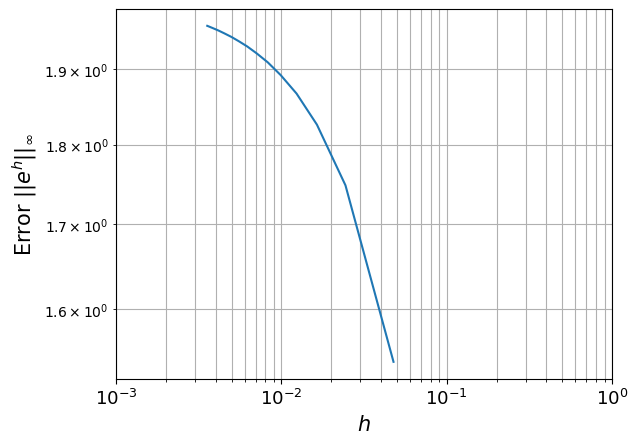

In [ ]:
LABELSIZE = 15

fig, ax = plt.subplots()
h_values, errors, A_norm = convergence(np.arange(20, 300, step=20))
ax.loglog(h_values, errors)
ax.grid(visible=True, which="both")
ax.set_xlabel("$h$", size=LABELSIZE)
ax.set_ylabel(r"Error $||e^h||_\infty$", size=LABELSIZE)
ax.set_xticks(np.logspace(-3, 0, num=4))
ax.tick_params(axis="both", which="major", labelsize=LABELSIZE-2)

In [ ]:
xy = np.linspace(0, 1, 11)
X, Y = np.meshgrid(xy, xy, indexing="xy")

print("xy")
printmatrix(xy, fp=1, bs=4)
print("X =")
printmatrix(X, fp=1, bs=4)
print("Y = ")
printmatrix(Y, fp=1, bs=4)

xy
[ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
X =
[[ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]
 [ 0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0]]
Y = 
[[ 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
 [ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]
 [ 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4]
 [